# psd_cs_ccf.ipynb
Abbie Stevens (<abigailstev@gmail.com>), 2022

In [1]:
import numpy as np
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray import Powerspectrum, AveragedPowerspectrum, AveragedCrossspectrum
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/fourier.py:18: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crosscorrelation.py:9: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/bispectrum.py:11: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
homedir = os.path.expanduser('~')
exe_dir = os.getcwd()
obj_name = "Swift_J0243.6+6124"
obj_prefix = "J0243"
data_dir = '%s/Reduced_data/%s/' % (homedir, obj_name)
listdir = "%s/Documents/Research/%s/in" % (homedir, obj_prefix)
assert os.path.isdir(data_dir)
data_file = "%sobs113_bary.evt" % (data_dir)
assert os.path.isfile(data_file)

In [3]:
dt = 1./2.
n_seconds = int(64)  # length of light curve segment, in seconds
broad_le = 0.2
broad_he = 12.
ref_le = 0.2
ref_he = 12.
b1_le = 0.2  # keV
b1_he = 1.  # keV
b2_le = 1.  # keV
b2_he = 2.  # keV
b3_le = 2.  # keV
b3_he = 3.  # keV
hard_le = 3.  # keV
hard_he = 12.  # keV

out_file = "%s/out/%s_%dsec_%ddt_psd-cs.fits" % \
           (exe_dir, obj_prefix, n_seconds, int(1/dt))

In [4]:
datatab = Table.read(data_file, format='fits', hdu=1)
## All MPUs, 0.2-12 keV
broad_mask = (datatab['PI'] >= int(broad_le*100)) & \
             (datatab['PI'] <= int(broad_he*100))
datatab = datatab[broad_mask]

In [5]:
gtitab = Table.read(data_file, format='fits', hdu=2)
print(gtitab)
gtis = [[i,j] for i,j in zip(gtitab['START'], gtitab['STOP'])]

      START               STOP       
        s                  s         
------------------ ------------------
120970834.86620812 120971402.88879049
120971407.88897188 120971419.88940565
120976626.02114478 120976980.03472188
120992868.43637262 120992869.43641537
120992871.43650085 120993723.97255741
120993723.97304083 120993757.95188123
120993757.95422462 120993920.47681308
121009532.86550564 121010600.90631835
121015087.00767943 121016024.04429896
121016027.04439765 121016040.04482351


## Masking for event list selections
Use masks to select the energies and detectors for analysis

In [6]:
## MPUs 0-3 are CI
## MPUs are marked by the 1st digit (0-6 incl) in the detector ID
ci_mask = datatab['DET_ID'] < 40
evts_ci = datatab[ci_mask]

## MPUs 4-6 are REF (i.e., the other ones that aren't CI)
evts_ref = datatab[~ci_mask]
## Also want ref to be 0.2-12 keV
ref_mask = (evts_ref['PI'] >= int(ref_le*100)) & \
           (evts_ref['PI'] <= int(ref_he*100))
evts_ref = evts_ref[ref_mask]

In [7]:
## All MPUs, soft band 1
b1_mask = (datatab['PI'] >= int(b1_le*100)) & \
          (datatab['PI'] < int(b1_he*100))
evts_b1 = datatab[b1_mask]

## All MPUs, soft band 2
b2_mask = (datatab['PI'] >= int(b2_le*100)) & \
          (datatab['PI'] < int(b2_he*100))
evts_b2 = datatab[b2_mask]

## All MPUs, soft band 3
b3_mask = (datatab['PI'] >= int(b3_le*100)) & \
          (datatab['PI'] < int(b3_he*100))
evts_b3 = datatab[b3_mask]

## All MPUs, hard band
hard_mask = (datatab['PI'] >= int(hard_le*100)) & \
            (datatab['PI'] <= int(hard_he*100))
evts_hard = datatab[hard_mask]

## Reference band
Make light curve and average power spectrum.

In [8]:
lc_ref = Lightcurve.make_lightcurve(evts_ref['TIME'], dt=dt, gti=gtis)
ps_ref = AveragedPowerspectrum(lc_ref, segment_size=n_seconds, norm='abs')

## Broad band

In [16]:
lc_broad = Lightcurve.make_lightcurve(datatab['TIME'], dt=dt, gti=gtis)
ps_broad = AveragedPowerspectrum(lc_broad, segment_size=n_seconds, norm='abs')

## Band 1
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [9]:
lc_b1 = Lightcurve.make_lightcurve(evts_b1['TIME'], dt=dt, gti=gtis)
ps_b1 = AveragedPowerspectrum(lc_b1, segment_size=n_seconds, norm='abs')
cs_b1 = AveragedCrossspectrum(lc_b1, lc_ref, segment_size=n_seconds)

## Band 2
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [10]:
lc_b2 = Lightcurve.make_lightcurve(evts_b2['TIME'], dt=dt, gti=gtis)
ps_b2 = AveragedPowerspectrum(lc_b2, segment_size=n_seconds, norm='abs')
cs_b2 = AveragedCrossspectrum(lc_b2, lc_ref, segment_size=n_seconds)

## Band 3
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [11]:
lc_b3 = Lightcurve.make_lightcurve(evts_b3['TIME'], dt=dt, gti=gtis)
ps_b3 = AveragedPowerspectrum(lc_b3, segment_size=n_seconds, norm='abs')
cs_b3 = AveragedCrossspectrum(lc_b3, lc_ref, segment_size=n_seconds)

## Hard band
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [12]:
lc_hard = Lightcurve.make_lightcurve(evts_hard['TIME'], dt=dt, gti=gtis)
ps_hard = AveragedPowerspectrum(lc_hard, segment_size=n_seconds, norm='abs')
cs_hard = AveragedCrossspectrum(lc_hard, lc_ref, segment_size=n_seconds)

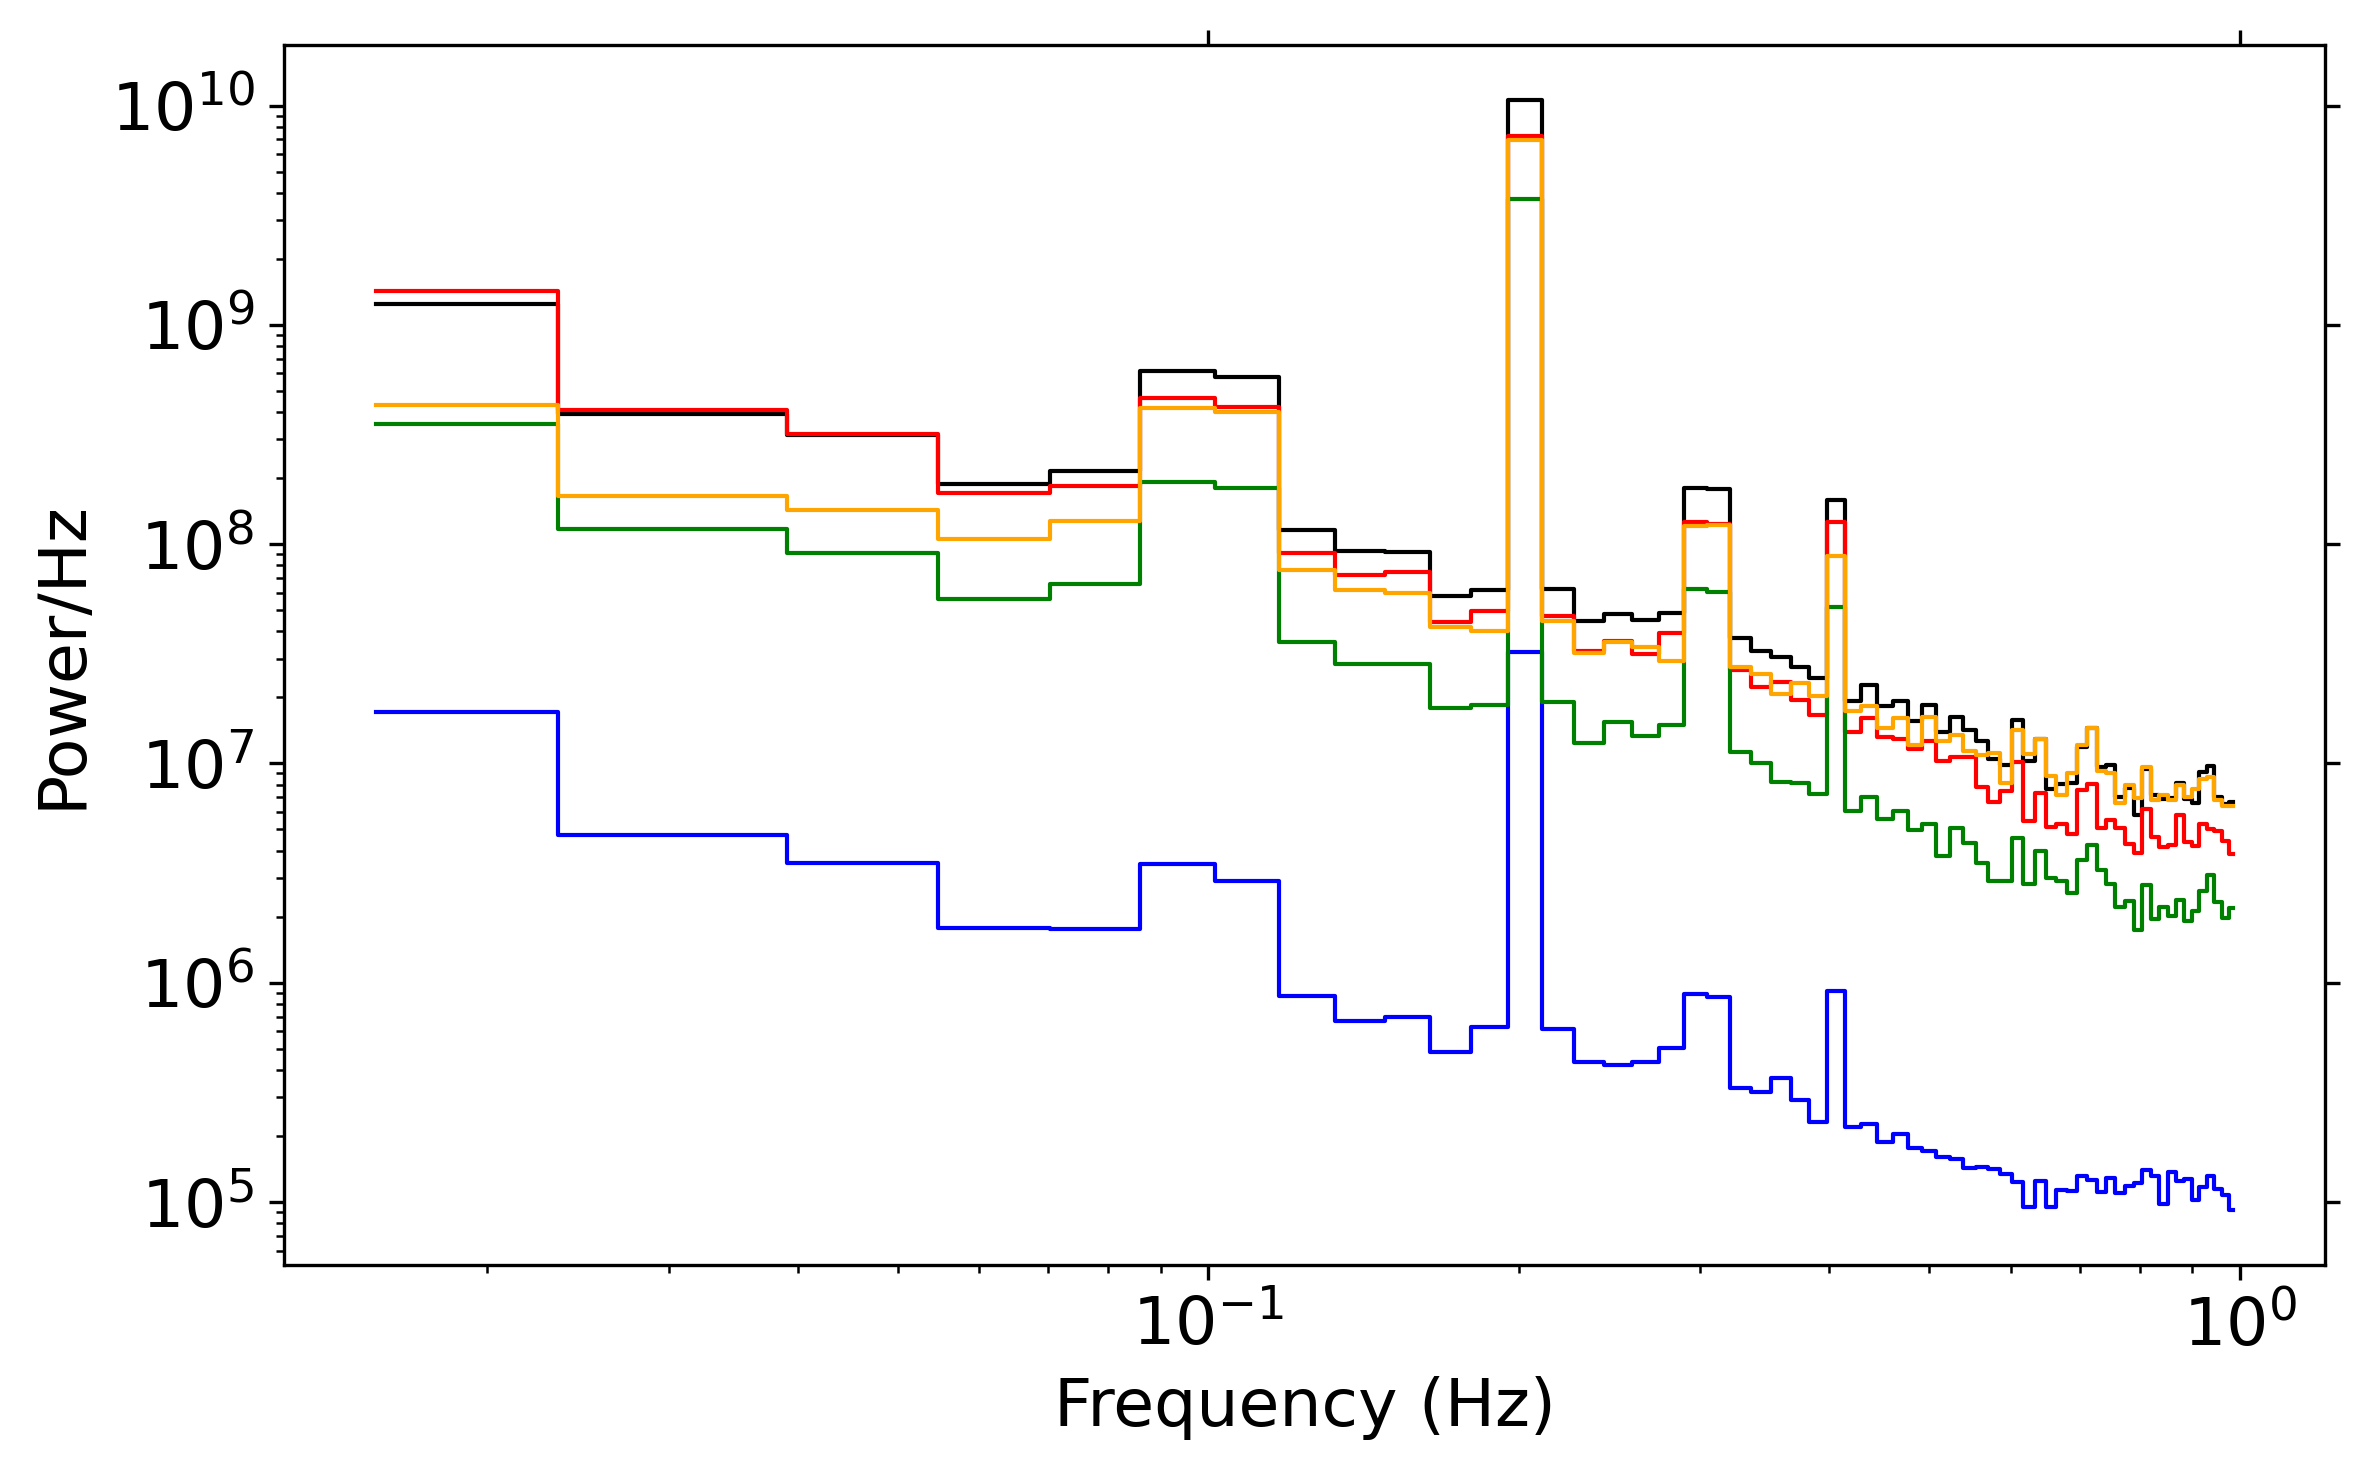

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps_ref.freq, ps_ref.power, lw=1, drawstyle='steps-mid', color='black')
ax.plot(ps_b1.freq, ps_b1.power, lw=1, drawstyle='steps-mid', color='blue')
ax.plot(ps_b2.freq, ps_b2.power, lw=1, drawstyle='steps-mid', color='red')
ax.plot(ps_b3.freq, ps_b3.power, lw=1, drawstyle='steps-mid', color='green')
ax.plot(ps_hard.freq, ps_hard.power, lw=1, drawstyle='steps-mid', color='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## Channels of interest ("CI")
Make individual light curves and cross spectra of each of those with the reference band. 

In [14]:
ci_dets = np.unique(evts_ci['DET_ID'])
n_ci_dets = len(ci_dets)
n_bins = int(n_seconds/dt)
print(n_bins)

DET_ID
------
     0
     1
     2
     3
     4
     5
     6
   ...
    31
    32
    33
    34
    35
    36
    37
Length = 29 rows 29


In [17]:
ps_ci = np.asarray([])
cs_ci = np.asarray([])
for i in range(n_ci_dets):
    indiv_det_mask = evts_ci['DET_ID'] == ci_dets[i]
    evts_det = evts_ci[indiv_det_mask]
    lc_det = Lightcurve.make_lightcurve(evts_det['TIME'], dt=dt, gti=gtis)
    ps_det = AveragedPowerspectrum(lc_det, segment_size=n_seconds, norm='none')
    ps_ci = np.append(ps_ci, ps_det)
    cs_det = AveragedCrossspectrum(lc_det, lc_ref, segment_size=n_seconds, fullspec=True)
    cs_ci = np.append(cs_ci, cs_det)

128


In [18]:
print(np.shape(cs_ci))
print(cs_ci[0])

(29,)


## Making the ccf from the average cross spectra

In [ ]:
ccf = np.zeros((ps_ref.n, n_ci_dets))


In [ ]:
ref_rms = np.sqrt(np.sum(ps_ref.power * ps_ref.df))  ## Assuming absolute rms normalization
print(ref_rms)
ccf *= 2.0 / float(n_bins) / ref_rms

In [ ]:
    print("* Computing ccf err")
    ref_rms = np.sqrt(np.sum(psd_ref[0:int(n_bins / 2)] * df))
    print(ref_rms)
    mean_ccf = np.mean(ccf, axis=2)
    ## Compute the standard error on each ccf bin from the segment-
    ## to-segment variations.
    ccf_resid = (ccf.T - mean_ccf.T).T
    ## Eqn 2.3 from S. Vaughan 2013, "Scientific Inference"
    sample_var = np.sum(ccf_resid ** 2, axis=2) / (n_seg - 1)
    ## Eqn 2.4 from S. Vaughan 2013, "Scientific Inference"
    ccf_err = np.sqrt(sample_var / n_seg)